### **Reading the dataset**

In [0]:
import pandas as pd
import numpy as np

#Reading the dataset
dataset=pd.read_csv("time_series_covid_19_confirmed.csv")

#the dataset contained data uptil 28th MAy so the last column needs to be dropped
dataset=dataset[dataset.columns[:-1]] 



### **Forming correlation matrix**

In [332]:
dataset_covid = dataset

#columns which are not needed are dropped
dataset_covid=dataset_covid.drop(['Province/State','Lat','Long'],axis=1)

#Putting dailycases for same countries into single row
dataset_covid = dataset_covid.groupby("Country/Region").sum()

#Calculating correlations
dataset_new=dataset_covid.T
corr_matrix=dataset_new.corr()
corr_matrix

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei,Bulgaria,Burkina Faso,Burma,Burundi,Cabo Verde,Cambodia,Cameroon,Canada,Central African Republic,Chad,Chile,China,Colombia,Comoros,Congo (Brazzaville),...,Senegal,Serbia,Seychelles,Sierra Leone,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Taiwan*,Tajikistan,Tanzania,Thailand,Timor-Leste,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Uganda,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.000000,0.823104,0.941343,0.665803,0.934209,0.673239,0.976714,0.987806,0.637402,0.654487,0.947948,0.808833,0.981587,0.998092,0.705436,0.971872,0.787539,0.685429,0.784143,0.961842,0.999618,0.845839,0.839828,0.998610,0.545807,0.896884,0.776682,0.848318,0.964007,0.968839,0.555678,0.974380,0.890339,0.975059,0.989202,0.997734,0.295153,0.988759,0.872638,0.954117,...,0.983391,0.832757,0.554156,0.996106,0.939692,0.760263,0.663073,0.970442,0.996786,0.942746,0.713110,0.936310,0.992476,0.590389,0.892880,0.663117,0.901202,0.619752,0.963796,0.844746,0.660982,0.752030,0.977837,0.591453,0.717432,0.840425,0.878249,0.940476,0.942643,0.965727,0.876868,0.753436,0.882036,0.969609,0.673825,0.744547,0.741682,0.965900,0.977536,0.891466
Albania,0.823104,1.000000,0.961972,0.961200,0.965481,0.963164,0.922478,0.899144,0.939564,0.948153,0.956781,0.995917,0.907787,0.825365,0.971104,0.899546,0.996429,0.958212,0.806499,0.867066,0.814215,0.996227,0.981495,0.842523,0.859274,0.983871,0.993348,0.977072,0.840309,0.888421,0.873306,0.924216,0.984044,0.704092,0.783784,0.850831,0.477051,0.895357,0.551317,0.939847,...,0.882889,0.987991,0.874920,0.806674,0.932792,0.991942,0.957429,0.879748,0.861801,0.637451,0.979147,0.953320,0.755047,0.886540,0.987830,0.957276,0.941260,0.927645,0.660896,0.944637,0.957311,0.946275,0.895222,0.910758,0.982437,0.989166,0.990052,0.911877,0.942556,0.930085,0.987422,0.984538,0.981067,0.881272,0.939683,0.984088,0.948726,0.671066,0.759268,0.919076
Algeria,0.941343,0.961972,1.000000,0.858895,0.993965,0.866592,0.985773,0.977969,0.829158,0.842355,0.996165,0.957243,0.985661,0.944895,0.883976,0.982630,0.945180,0.874206,0.858403,0.943467,0.935843,0.975173,0.958394,0.954113,0.730461,0.992195,0.934693,0.968643,0.932731,0.976750,0.744574,0.987874,0.990919,0.853482,0.920053,0.954101,0.398394,0.980862,0.704706,0.992915,...,0.975803,0.966944,0.745566,0.934631,0.988174,0.929039,0.853211,0.972609,0.961903,0.793642,0.893759,0.991855,0.899264,0.768047,0.991651,0.853440,0.952792,0.811630,0.823896,0.955048,0.853277,0.906368,0.972758,0.787811,0.899992,0.970815,0.987146,0.966133,0.994164,0.993970,0.986823,0.914329,0.983964,0.948311,0.843646,0.910948,0.889850,0.832783,0.895344,0.937787
Andorra,0.665803,0.961200,0.858895,1.000000,0.879127,0.994148,0.806203,0.772682,0.994445,0.995605,0.859554,0.953437,0.774888,0.660123,0.997180,0.751366,0.969699,0.969235,0.692211,0.755953,0.654235,0.942157,0.929113,0.686829,0.934192,0.900099,0.983678,0.897427,0.703868,0.737877,0.951787,0.804340,0.900254,0.536121,0.614831,0.707762,0.517198,0.758689,0.398988,0.820545,...,0.736323,0.923369,0.951271,0.637637,0.799336,0.971000,0.995368,0.722113,0.718593,0.472391,0.996795,0.839508,0.581753,0.958539,0.909723,0.997783,0.873196,0.984708,0.488482,0.836001,0.999115,0.885492,0.776952,0.981380,0.993504,0.925106,0.917999,0.810326,0.817567,0.801373,0.910850,0.988172,0.900668,0.772593,0.982120,0.989708,0.944060,0.498823,0.599707,0.837005
Angola,0.934209,0.965481,0.993965,0.879127,1.000000,0.885403,0.985432,0.976201,0.854075,0.865411,0.995158,0.957863,0.976048,0.932829,0.903416,0.965763,0.949633,0.885572,0.838

### **Checking correlations for Pakistan to figure out top 5 Countries having same trend**

In [333]:
print("Correlation of all the countries with Pakistan is")
relation=corr_matrix['Pakistan'].sort_values(ascending=False)
print(relation)

print("\n\nTop five countries that have similar trend of spread as Pakistan are")
print(relation.head(6))

Correlation of all the countries with Pakistan is
Country/Region
Pakistan            1.000000
Saudi Arabia        0.998967
Qatar               0.998740
Colombia            0.998703
Peru                0.998608
                      ...   
Seychelles          0.629382
Brunei              0.618739
Korea, South        0.559237
China               0.335740
Diamond Princess    0.331548
Name: Pakistan, Length: 188, dtype: float64


Top five countries that have similar trend of spread as Pakistan are
Country/Region
Pakistan        1.000000
Saudi Arabia    0.998967
Qatar           0.998740
Colombia        0.998703
Peru            0.998608
Egypt           0.998586
Name: Pakistan, dtype: float64


### **Plotting the results**

Text(0.5, 1.0, 'Countries that have same spread trend for COVID19, as Pakistan')

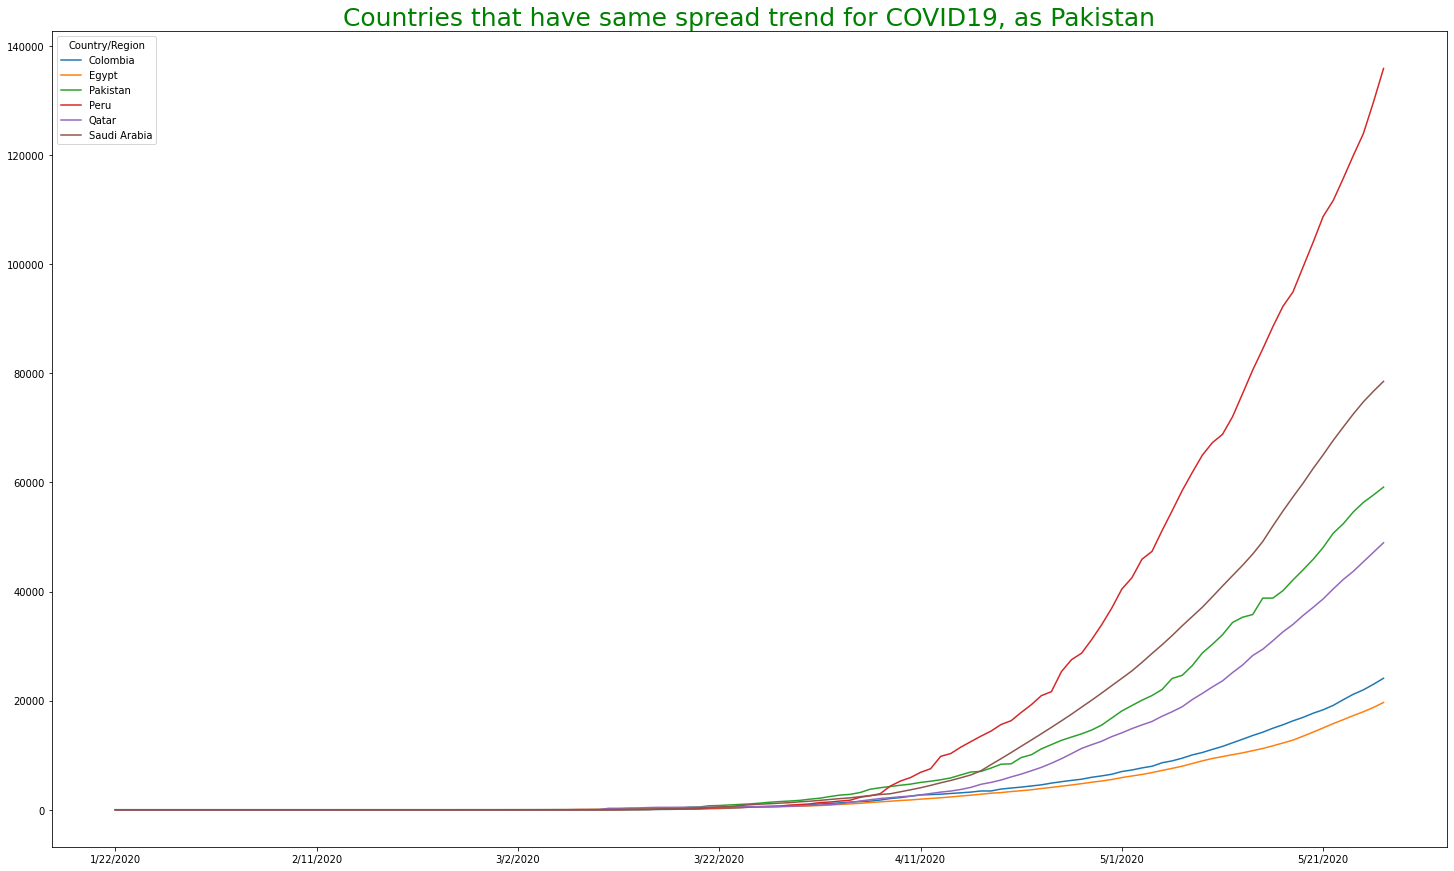

In [334]:
#plotting data for the countries which have similar spread trend as Pakistan

import matplotlib.pyplot as plt

#keeping those countries that have same spread trend as Pakistan
def keep_cols(Data, keep_them):
    drop_them = list(set(list(Data)) - set(keep_them))
    return Data.drop(drop_them, axis = 1)

final_data = dataset_new.pipe(keep_cols, ['Pakistan', 'Saudi Arabia','Colombia','Qatar','Peru','Egypt'])
#final_data=final_data.drop(['Lat','Long'])
#print(final_data)
final_data.plot(figsize=(25,15))
plt.title("Countries that have same spread trend for COVID19, as Pakistan",fontsize=25,color='green')


### **Preparing data for training(Getting everyday cases for 5 countries)**

In [335]:
#dropping pakistan from data in order to train the model on data of saudi arabia,peru,egypt,qatar and columbia

drop_pak=final_data.drop(['Pakistan'],axis=1)
#drop_pak=drop_pak.drop(['Lat','Long'],axis=0)
drop_pak=drop_pak.T


#print(drop_pak)
cases = drop_pak.sum(axis=0)
cases.index = pd.to_datetime(cases.index)
print("sum of daily cases of 5 countries are")
print(cases)
cases2=cases

#calculating new cases reported each day (subtracting current value from previous value)
cases = cases.diff().fillna(cases[0]).astype(np.int64)
print('\n#n Number of new cases reported each day\n',cases)
train_data=cases[:-17]
test_data=cases[-17:]


sum of daily cases of 5 countries are
2020-01-22         0
2020-01-23         0
2020-01-24         0
2020-01-25         0
2020-01-26         0
               ...  
2020-05-23    264818
2020-05-24    274673
2020-05-25    284187
2020-05-26    295443
2020-05-27    307163
Length: 127, dtype: int64

#n Number of new cases reported each day
 2020-01-22        0
2020-01-23        0
2020-01-24        0
2020-01-25        0
2020-01-26        0
              ...  
2020-05-23    10003
2020-05-24     9855
2020-05-25     9514
2020-05-26    11256
2020-05-27    11720
Length: 127, dtype: int64


In [336]:
#getting information of the dataset

cases.describe()

count      127.000000
mean      2418.606299
std       3412.427849
min          0.000000
25%          0.000000
50%        272.000000
75%       4138.000000
max      11720.000000
dtype: float64

In [337]:
train_data.describe()

count     110.000000
mean     1357.618182
std      2159.595494
min         0.000000
25%         0.000000
50%       138.000000
75%      2029.000000
max      7423.000000
dtype: float64

### **Making sequences of data**

In [0]:
'''Data will be dividedd into sequences of certian length.if length of sequence is 7 for example than the
8th values in the dataset would be considered as label which is to be predicted by the model'''

def data_sequence(dataset, length):
    label = []
    x = []
    for i in range(len(dataset)-length-1):
        x_value = dataset[i:(i+length)]
        label_value = dataset[i+length]
        x.append(x_value)
        label.append(label_value)
    return np.array(x), np.array(label)



### **Model**

Autoregression is implemented in statsmodel in python.As it was not allowed I  tried making an autoregression model using the formula


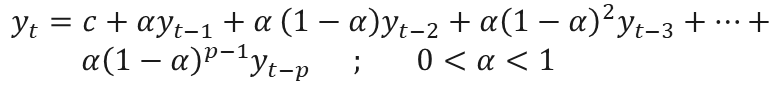


In [0]:
from math import pow

def COVID_prediction(X_all,seq_len,y_all):
  l=len(y_all)
  predicted=[]
  for i in range(0,l):
    p=seq_len
    alpha=(1/p)
    #print(X_all[i])
    lists=X_all[i]
    c=1357
    pred=c # mean of the data is taken as constant c
    for i in range(p):
      pred+=alpha*(pow(1-alpha,i))*lists[p-1-i]
    #pred=(alpha*lists[7])+(alpha*(1-alpha)*lists[6])+(alpha*(pow(1-alpha,2))* lists[5] )+(alpha*(pow(1-alpha,3))*lists[4] )+ (alpha*(pow(1-alpha,4))*lists[3])+(alpha*(pow(1-alpha,5))*lists[2])+ (alpha*(pow(1-alpha,6))*lists[1])+ (alpha*(pow(1-alpha,7))*lists[0])
    #pred=(alpha*lists[4])+(alpha*lists[3])+(alpha* lists[2] )+(alpha*lists[1] )+ (alpha*lists[0])
    #pred=(alpha*lists[4])+(alpha*(1-alpha)*lists[3])+(alpha*(pow(1-alpha,2))* lists[2] )+(alpha*(pow(1-alpha,3))*lists[1] )+ (alpha*(pow(1-alpha,4))*lists[0])
    predicted.append(pred)
  return predicted



### **Training**

In [340]:
length=3
X_all, y_all = data_sequence(train_data, length)
model=COVID_prediction(X_all,length,y_all)
print(model)
print(len(model))

[1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.3333333333333, 1357.2222222222222, 1357.148148148148, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.3333333333333, 1358.2222222222222, 1358.148148148148, 1358.9999999999998, 1358.3703703703702, 1359.4814814814815, 1362.9259259259259, 1360.8518518518517, 1376.4074074074074, 1373.2222222222224, 1374.8148148148148, 1445.7407407407409, 1426.4444444444446, 1444.2222222222222, 1418.1851851851852, 1421.6666666666665, 1439.3703703703702, 1450.8148148148148, 1434.4444444444443, 1482.888888888889, 1472.0, 1500.1851851851852, 1507.5555555555557, 1502.3703703703702, 1561.5185185185185, 1587.148148148148, 1587.814814814815, 1555.5555555555554, 1545.0740740740741, 1603.6666666666665, 1648.1851851851852, 1682.5925925925926, 1762.1481481481483, 1766.2592592592594, 1811.9259259

106
106
actual=blue


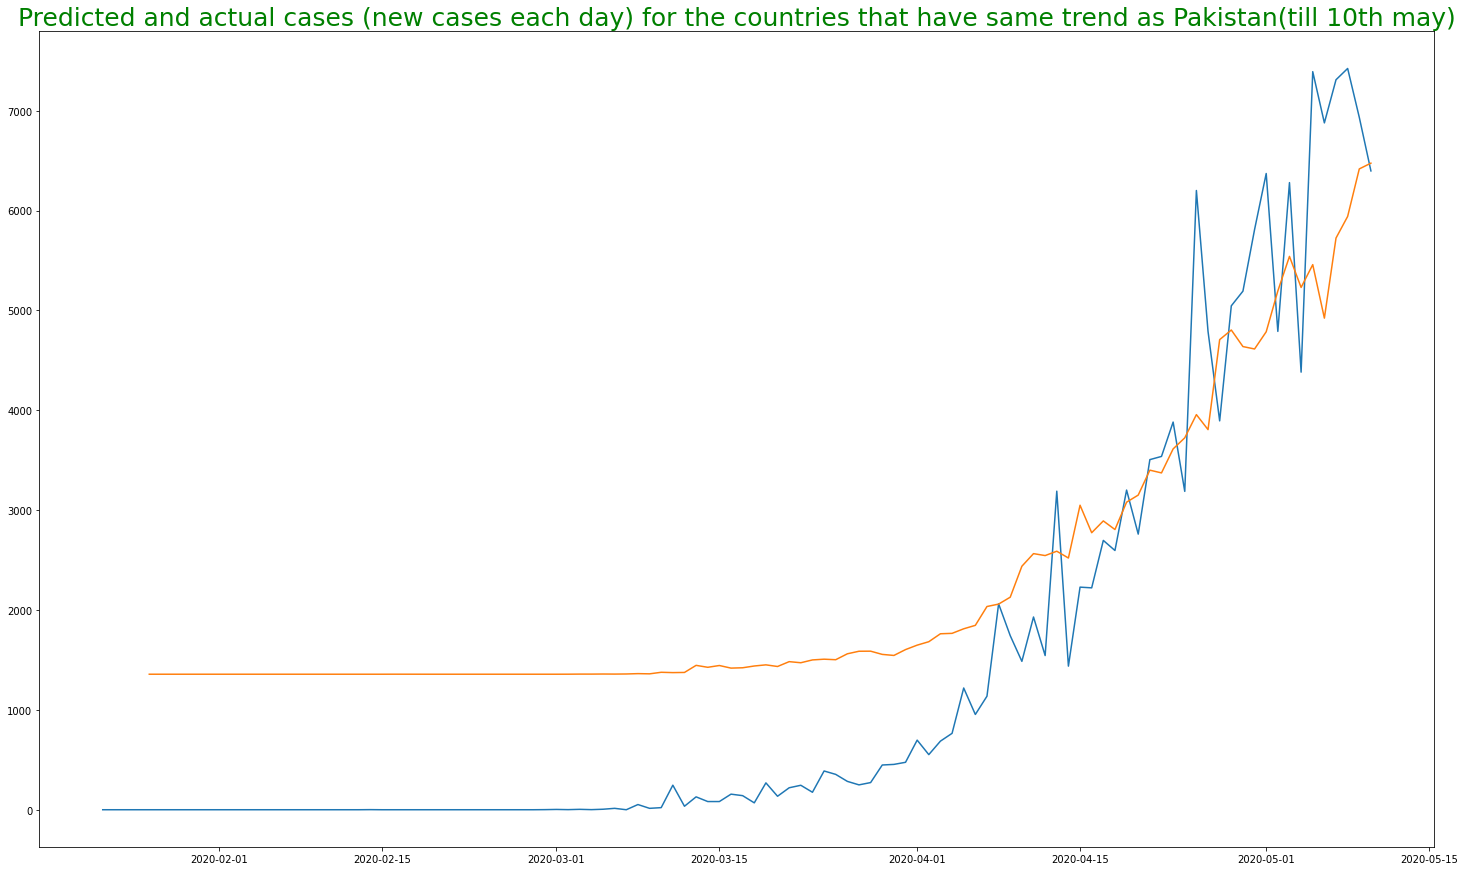

In [341]:
import matplotlib
predicted=model

#predicted values are added to the dataframe and then actual and predicted values are plotted
xaxis=pd.date_range(start="2020-01-26",end="2020-05-10")
print(len(model))
print(len(xaxis))

df = pd.DataFrame(index=xaxis) 
df['predictions']=predicted
df.predictions=pd.to_numeric(df.predictions)
#plt.figure()

plt.figure(figsize=(25,15))

plt.plot(train_data)
plt.plot(df)
plt.title("Predicted and actual cases (new cases each day) for the countries that have same trend as Pakistan(till 10th may)",fontsize=25,color='green')
print("actual=blue")

### **Testing**

In [344]:
#Checking how good the model performed using data 10th may-27th may

length=2
X_test, y_test = data_sequence(test_data, length)
model_test=COVID_prediction(X_test,length,y_test)
print(model_test)
print(len(model_test))


[6567.0, 7546.0, 8065.5, 7822.0, 8269.5, 8391.25, 7605.25, 8353.5, 8979.0, 9037.0, 8412.5, 8604.75, 8785.25, 8577.75]
14


14
14
actual=blue


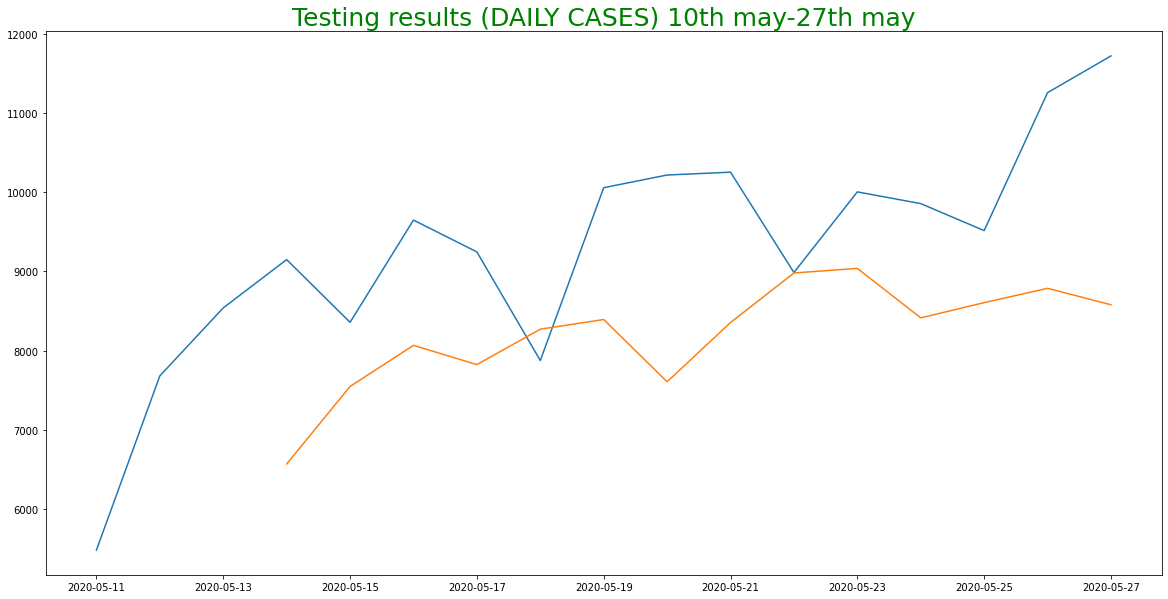

In [345]:
predicted=model_test

#predicted values are added to the dataframe and then actual and predicted values are plotted
xaxis=pd.date_range(start="2020-05-14",end="2020-05-27")
print(len(model_test))
print(len(xaxis))

df1 = pd.DataFrame(index=xaxis) 
df1['predictions']=predicted
df1.predictions=pd.to_numeric(df1.predictions)
#plt.figure()

plt.figure(figsize=(20,10))

plt.plot(test_data)
plt.plot(df1)
plt.title("Testing results (DAILY CASES) 10th may-27th may",fontsize=25,color='green')
print("actual=blue")

In [348]:


difference=[]
#test_data=test_data[3:]
print("error in each prediction for test data is: \n")
for z in range (0,14):
  diff=abs(test_data[z]-model_test[z])
  difference.append(diff)
  print((diff/test_data[z])*100,'% ')


error in each prediction for test data is: 

19.835766423357665 % 
1.7447916666666667 % 
5.534082923401265 % 
14.494971578487101 % 
1.0351842987075155 % 
13.017000103659168 % 
17.736614386154677 % 
6.089662179324359 % 
10.710023866348449 % 
11.5407204385278 % 
17.94284042138119 % 
4.232053422370618 % 
12.173847845646305 % 
12.960426179604262 % 


### **Using model to predict results for Pakistan**

In [350]:
pakistan=final_data['Pakistan']
month=pakistan
pakistan=pakistan[:-17]

paki= pakistan.diff().fillna(cases[0]).astype(np.int64)
print('Number of new cases reported each day in pakistan are \n',paki)

seq_length=3
X_pak, y_pak = data_sequence(paki, seq_length)
model_pak=COVID_prediction(X_pak,seq_length,y_pak)
print("\n\npredictions for pakistan(uptil 10may)\n",model_pak)
print(len(model_pak))

Number of new cases reported each day in pakistan are 
 1/22/2020       0
1/23/2020       0
1/24/2020       0
1/25/2020       0
1/26/2020       0
             ... 
5/6/2020     2024
5/7/2020      571
5/8/2020     1791
5/9/2020     2301
5/10/2020    1598
Name: Pakistan, Length: 110, dtype: int64


predictions for pakistan(uptil 10may)
 [1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.0, 1357.6666666666667, 1357.4444444444443, 1357.2962962962963, 1357.6666666666667, 1357.4444444444443, 1357.2962962962963, 1357.3333333333333, 1357.2222222222222, 1357.148148148148, 1357.3333333333333, 1357.2222222222222, 1357.148148148148, 1357.0, 1360.3333333333333, 1360.2222222222222, 1359.4814814814815, 1360.3333333333333, 1359.9259259259259, 1366.1851851851852, 1390.0, 1412.037037037037, 1412.

###  **Prediction for Pakistan(10th may - 27th June)**

In [351]:

month = month.diff().fillna(cases[0]).astype(np.int64)
month2=month
month=month[-17:]
#series=pd.Series(month)

print('New cases each day in pakistan 10-27 may\n',month)

New cases each day in pakistan 10-27 may
 5/11/2020    1747
5/12/2020    2255
5/13/2020     962
5/14/2020     490
5/15/2020    3011
5/16/2020       0
5/17/2020    1352
5/18/2020    1974
5/19/2020    1841
5/20/2020    1932
5/21/2020    2193
5/22/2020    2603
5/23/2020    1743
5/24/2020    2164
5/25/2020    1748
5/26/2020    1356
5/27/2020    1446
Name: Pakistan, dtype: int64


In [352]:
length_pak=2
X_pred, y_pred = data_sequence(month, length_pak)
model_pred = COVID_prediction(X_pred,length_pak,y_pred)


DAYS_TO_PREDICT = 30
array=[]
array.append(model_pred[-3:])
test_seq = array
y=y_pred[-1:]
preds = []

for i in range(DAYS_TO_PREDICT):
    pred= COVID_prediction(test_seq,length_pak,y)
    preds.append(pred)
    test_seq=np.append(test_seq,pred)
    test_seq=np.delete(test_seq,0)
    
    array2=[]
    array2.append(test_seq)
    test_seq=array2
    
    
predicted2 = []
for sublist in preds:
    for item in sublist:
        predicted2.append(item)
check=[]
check.extend(model_pred)
check.extend(predicted2)
print(check)
print(len(check))

[2921.25, 2401.75, 1842.5, 2985.0, 2109.75, 2033.0, 2682.0, 2771.0, 2783.25, 2936.5, 3206.75, 2879.25, 2874.75, 2772.0, 3514.1875, 3461.6875, 3807.09375, 3966.390625, 4125.96875, 4291.96875, 4411.58203125, 4534.4765625, 4635.783203125, 4727.1337890625, 4808.5107421875, 4879.5126953125, 4943.038818359375, 4998.884033203125, 5048.3975830078125, 5092.201721191406, 5130.9197998046875, 5165.200256347656, 5195.510330200195, 5222.330078125, 5246.055229187012, 5267.042621612549, 5285.610134124756, 5302.035118103027, 5316.565722465515, 5329.420092582703, 5340.791640758514, 5350.85147690773, 5359.750843524933, 5367.623648643494]
44


In [353]:
paki_plot=final_data['Pakistan']
paki_plot= paki_plot.diff().fillna(cases[0]).astype(np.int64)
paki_plot=paki_plot[:-17]
print(paki_plot)

1/22/2020       0
1/23/2020       0
1/24/2020       0
1/25/2020       0
1/26/2020       0
             ... 
5/6/2020     2024
5/7/2020      571
5/8/2020     1791
5/9/2020     2301
5/10/2020    1598
Name: Pakistan, Length: 110, dtype: int64


### **Plotting daily new cases(actual and predicted)**
Note: The following data was not being plot by matplotlib so plotly was used to plot graph

In [377]:
import plotly.graph_objects as g
predicted2=check

#predicted values are added to the dataframe and then actual and predicted values are plotted
xaxis=pd.date_range(start="2020-05-15",end="2020-06-27")

df2 = pd.DataFrame(index=xaxis) 
df2['predictions']=predicted2


fig_covid = g.Figure()
fig_covid.add_trace(g.Scatter(x=paki_plot.index, y=paki_plot, mode='lines+markers', name='actual',line=dict(color='blue', width=1)))
fig_covid.add_trace(g.Scatter(x=xaxis, y=df2['predictions'], mode='lines+markers', name='predicted', line=dict(color='green', width=1)))

fig_covid.update_layout(title='Predicted and actual cases (new cases each day) for the Pakistan ', xaxis_tickfont_size=14,yaxis=dict(title='Number of Cases'))
fig_covid.show()


### **Cummulative graph**

In [378]:
cumm_graph=final_data['Pakistan']
series2 = pd.Series(df2.predictions) 
# making cummulative series 
cumsum2 = series2.cumsum() 

xa=pd.date_range(start="2020-01-26",end="2020-05-10")
fig_covid = g.Figure()
fig_covid.add_trace(g.Scatter(x=cumm_graph.index, y=cumm_graph, mode='lines+markers', name='actual',line=dict(color='blue', width=1)))
fig_covid.add_trace(g.Scatter(x=xaxis, y=cumsum2, mode='lines+markers', name='predicted', line=dict(color='green', width=1)))

fig_covid.update_layout(title='Cummulative graph for actual and predicted for the Pakistan ', xaxis_tickfont_size=14,yaxis=dict(title='Number of Cases'))
fig_covid.show()


### **Error calculation for Pakistani results**

In [373]:

a=final_data['Pakistan']
a=a.diff().fillna(cases[0]).astype(np.int64)
a=a[-18:]
p=predicted2[:18]
print(a)
print(p)




5/10/2020    1598
5/11/2020    1747
5/12/2020    2255
5/13/2020     962
5/14/2020     490
5/15/2020    3011
5/16/2020       0
5/17/2020    1352
5/18/2020    1974
5/19/2020    1841
5/20/2020    1932
5/21/2020    2193
5/22/2020    2603
5/23/2020    1743
5/24/2020    2164
5/25/2020    1748
5/26/2020    1356
5/27/2020    1446
Name: Pakistan, dtype: int64
[2921.25, 2401.75, 1842.5, 2985.0, 2109.75, 2033.0, 2682.0, 2771.0, 2783.25, 2936.5, 3206.75, 2879.25, 2874.75, 2772.0, 3514.1875, 3461.6875, 3807.09375, 3966.390625]


In [374]:
difference2=[]
#test_data=test_data[3:]
print("Difference of each prediction and actual value is: \n")
for z in range (0,18):
  diff=abs(a[z]-p[z])
  difference2.append(diff)
  print(diff)
  #print((diff/a[z])*100,'% \n')


Difference of each prediction and actual value is: 

1323.25
654.75
412.5
2023.0
1619.75
978.0
2682.0
1419.0
809.25
1095.5
1274.75
686.25
271.75
1029.0
1350.1875
1713.6875
2451.09375
2520.390625
